In [11]:
import numpy as np
import matplotlib.pyplot as plt

# 实现了：
# 1.模拟多种类型verifier（诚实，非诚实，精明的非诚实）执行验证，输出验证成功率和它们的信誉值变化情况并绘图
# 2.实现了在系统启动初期 限制信誉值的增长（但可以下降）
# 3.实现了自动剔除低于信誉值阈值的verifier

# 随机种子设置
def set_seed(seed):
    np.random.seed(seed)  # numpy产生的随机数一致

set_seed(45)

In [12]:
def simulate_verifier_groups(
    n_epochs,
    lambda_,
    window_size,
    n_verifiers,
    proportions,
    group_size,
    attack_start,
):
    # Initialize verifiers
    types = ["honest", "attacker1", "attacker2"]
    verifiers = []
    for i, proportion in enumerate(proportions):
        for _ in range(int(n_verifiers * proportion)):
            verifiers.append(
                {
                    "type": types[i],
                    "reputation": 0.5,
                    "history": [],
                    "active": True,  # Indicator to check if verifier is still active
                }
            )

    # Simulation over epochs
    success_rates = []
    average_reputations = {"honest": [], "attacker1": [], "attacker2": []}

    # 使用优化算法获取特定数量满足要求的委员会
    for epoch in range(n_epochs):
        # 将信誉值大于阈值的verifier随机分组
        np.random.shuffle(verifiers)
        active_verifiers = [
            v for v in verifiers if v["active"]
        ]  # Only consider active verifiers
        groups = [
            active_verifiers[i : i + group_size]
            for i in range(0, len(active_verifiers), group_size)
        ]
        successful_groups = 0

        # 对于每一组，判断其是否验证成功
        for group in groups:
            results = []
            for verifier in group:
                if verifier["type"] == "honest":
                    result = 1  # no fail rate
                elif verifier["type"] == "attacker1":
                    result = 0 if np.random.rand() > 0.1 else 1  # 10% success rate
                else:  # smart_dishonest
                    if epoch < attack_start:
                        # result = (
                        #     1 if np.random.rand() > 0.1 else 0
                        # )  # 10% fail rate before attack
                        result = 1
                    else:
                        result = 0  # Always fail after attack start

                results.append(result)
                verifier["history"].append(result)

            # Majority-based validation outcome
            group_success = 1 if sum(results) > len(results) / 2 else 0
            successful_groups += group_success

            # Update reputations and deactivate low-reputation verifiers
            for verifier in group:
                weights = np.exp(
                    -lambda_ * np.arange(1, len(verifier["history"]) + 1)[::-1]
                )
                verifier["reputation"] = np.dot(
                    verifier["history"][-window_size:], weights[-window_size:]
                ) / np.sum(weights[-window_size:])
                # 在系统启动初期 限制信誉值的增长（但可以下降）
                if epoch < window_size and verifier["reputation"] > 0.5:
                    verifier["reputation"] = 0.5

        success_rate = successful_groups / len(groups) if groups else 0
        success_rates.append(success_rate)

        # Calculate and store average reputation for each type
        for verifier_type in average_reputations.keys():
            type_verifiers = [
                v["reputation"] for v in verifiers if v["type"] == verifier_type
            ]
            average_reputations[verifier_type].append(
                np.mean(type_verifiers) if type_verifiers else 0
            )

    return success_rates, verifiers, average_reputations

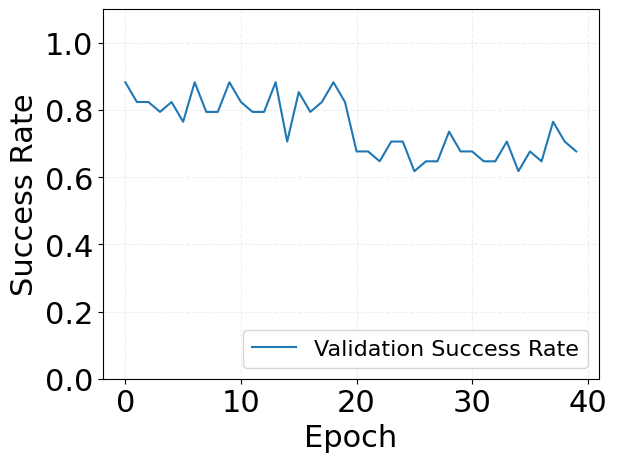

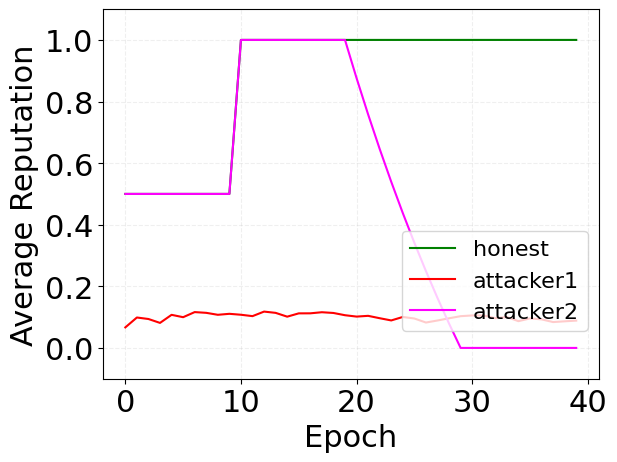

In [13]:
# Simulation settings
n_epochs = 40
lambda_ = 0.05
window_size = 10
n_verifiers = 100
proportions = [0.6, 0.3, 0.1]  # honest, dishonest, smart dishonest
group_size = 3
attack_start = 20

success_rates, verifiers, average_reputations = simulate_verifier_groups(
    n_epochs,
    lambda_,
    window_size,
    n_verifiers,
    proportions,
    group_size,
    attack_start,
)

# Plot validation success rates
plt.figure()
plt.yticks(fontsize=22)
plt.xticks(np.arange(0, 41, 10), fontsize=22)
plt.plot(success_rates, label="Validation Success Rate")
plt.xlabel("Epoch", fontsize=22)
plt.ylabel("Success Rate", fontsize=22)
plt.ylim(0, 1.1)  # Set y-axis range to 0-1
plt.legend(loc="lower right", fontsize=16)
plt.grid(ls="--", alpha=0.2)
plt.savefig(f"figures/reputation_succ_rate.pdf", dpi=300, bbox_inches="tight")

# Plot average reputation values for each verifier type
plt.figure()
plt.yticks(fontsize=22)
plt.xticks(np.arange(0, 41, 10), fontsize=22)
for color, (verifier_type, avg_reps) in zip(
    ["g", "r", "fuchsia"], average_reputations.items()
):
    plt.plot(avg_reps, label=f"{verifier_type}", color=color)
plt.xlabel("Epoch", fontsize=22)
plt.ylabel("Average Reputation", fontsize=22)
plt.ylim(-0.1, 1.1)  # Set y-axis range to 0-1
plt.legend(loc="lower right", bbox_to_anchor=(1, 0.1), fontsize=16)
plt.grid(ls="--", alpha=0.2)
plt.savefig(f"figures/reputation_avgrep.pdf", dpi=300, bbox_inches="tight")